In [1]:
%matplotlib inline
import fragmenter
import json 
from openeye import oechem, oequacpac, oedepict, oegraphsim
import matplotlib.pyplot as plt
import glob
import seaborn as sbn
import oenotebook as onb
import cmiles
import itertools
import numpy as np

In [16]:
def get_bond(mol, bond_tuple):
    a1 = mol.GetAtom(oechem.OEHasMapIdx(bond_tuple[0]))
    a2 = mol.GetAtom(oechem.OEHasMapIdx(bond_tuple[1]))
    if not a1 or not a2:
        print('no atoms')
        return False
    bond = mol.GetBond(a1, a2)
    if not bond:
        print('no bond')
        return False
    return bond

def visualize_mols(smiles, fname, rows, cols, bond_idx, wbos, colors, align_to=0):
    """
    Visualize molecules with highlighted bond and labeled with WBO
    Parameters
    ----------
    smiles : list of SMILES to visualize.
        bond atoms should have map indices
    fname : str
        filename
    rows : int
    cols : int
    bond_idx : tuple of atom maps of bond to highlight.
    wbos : list of floats
    colors : list of hex values for colors
    align_to: int, optional, default 0
        index for which molecule to align to. If zero, will align to first molecules in SMILES list

    """
    itf = oechem.OEInterface()

    ropts = oedepict.OEReportOptions(rows, cols)
    ropts.SetHeaderHeight(25)
    ropts.SetFooterHeight(25)
    ropts.SetCellGap(2)
    ropts.SetPageMargins(10)
    report = oedepict.OEReport(ropts)

    cellwidth, cellheight = report.GetCellWidth(), report.GetCellHeight()
    opts = oedepict.OE2DMolDisplayOptions(cellwidth, cellheight, oedepict.OEScale_AutoScale)
    oedepict.OESetup2DMolDisplayOptions(opts, itf)

    # align to chosen molecule
    ref_mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(ref_mol, smiles[align_to])
    oedepict.OEPrepareDepiction(ref_mol)

    mols = []
    minscale = float("inf")
    for s in smiles:
        mol = oechem.OEMol()
        oechem.OESmilesToMol(mol, s)
        mols.append(mol)
        oedepict.OEPrepareDepiction(mol, False, True)
        minscale = min(minscale, oedepict.OEGetMoleculeScale(mol, opts))

    opts.SetScale(minscale)
    for i, mol in enumerate(mols):

        cell = report.NewCell()
        oedepict.OEPrepareDepiction(mol, False, True)
        bond = get_bond(mol, bond_idx)
        atom_bond_set = oechem.OEAtomBondSet()
        atom_bond_set.AddAtoms([bond.GetBgn(), bond.GetEnd()])
        atom_bond_set.AddBond(bond)

        hstyle = oedepict.OEHighlightStyle_BallAndStick
        if i == 3:
            hcolor = oechem.OERed
        else:
            hcolor = oechem.OEColor(*colors[i])

        overlaps = oegraphsim.OEGetFPOverlap(ref_mol, mol, oegraphsim.OEGetFPType(oegraphsim.OEFPType_Tree))
        oedepict.OEPrepareMultiAlignedDepiction(mol, ref_mol, overlaps)

        disp = oedepict.OE2DMolDisplay(mol, opts)
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atom_bond_set)

        bond_label = oedepict.OEHighlightLabel("{:.2f}".format((wbos[i])), hcolor)
        oedepict.OEAddLabel(disp, bond_label, atom_bond_set)
        oedepict.OERenderMolecule(cell, disp)
        # oedepict.OEDrawCurvedBorder(cell, oedepict.OELightGreyPen, 10.0)

    return (oedepict.OEWriteReport(fname, report))

def rbg_to_int(rbg, alpha):
    """
    Convert rbg color to ints for openeye
    Parameters
    ----------
    rbg : list
        rbg
    alpha : int

    Returns
    -------
    list of ints

    """
    rbg[-1] = int(rbg[-1]*alpha)
    colors = [int(round(i*255)) for i in rbg[:-1]]
    colors.append(int(rbg[-1]))
    return colors


In [3]:
with open('Proguanil_0_wbo_dists.json', 'r') as f:
    results = json.load(f)

In [4]:
results = results['[14, 7]']

In [5]:
with open('Proguanil_0_pfizer_wbo_dists.json', 'r') as f:
    pfizer_results = json.load(f)

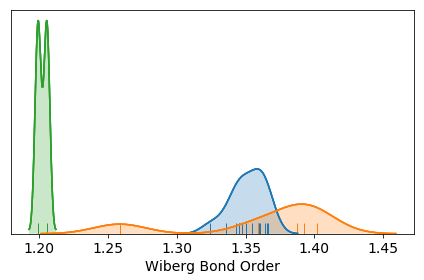

In [6]:
sbn.kdeplot(results['parent']['wbo_dist'], shade=True)
sbn.distplot(results['parent']['wbo_dist'], rug=True, hist=False, color=sbn.color_palette()[0])
sbn.distplot(results['parent']['wbo_dist'], hist=False, color=sbn.color_palette()[0])

sbn.kdeplot(results['0.03_path_length_False']['wbo_dist'], shade=True)
sbn.distplot(results['0.03_path_length_False']['wbo_dist'], rug=True, hist=False, color=sbn.color_palette()[1])
sbn.distplot(results['0.03_path_length_False']['wbo_dist'], hist=False, color=sbn.color_palette()[1])


sbn.kdeplot(pfizer_results['[14, 7]']['wbo_dist'], shade=True)
sbn.distplot(pfizer_results['[14, 7]']['wbo_dist'], rug=True, hist=False, color=sbn.color_palette()[2])
sbn.distplot(pfizer_results['[14, 7]']['wbo_dist'], hist=False, color=sbn.color_palette()[2])
plt.xticks(fontsize=14)
plt.yticks([])
plt.xlabel('Wiberg Bond Order', fontsize=14)
plt.tight_layout()
plt.savefig('wbo_dists.pdf')

In [17]:
colors = [rbg_to_int(list(i), alpha=255) for i in sbn.color_palette()[:3]]
wbos = [results['parent']['elf10_wbo'], results['0.03_path_length_False']['elf10_wbo'], pfizer_results['[14, 7]']['elf10_wbo']]
frags = [results['parent']['frag'], results['0.03_path_length_False']['frag'], pfizer_results['[14, 7]']['frag']]
visualize_mols(frags, cols=2, rows=2, bond_idx=(14, 7), colors=colors, wbos=wbos, fname='fragments.pdf', align_to=0)

True